In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import yaml
from pathlib import Path


sys.path.append('../')


# Make sure this import is after pandas
import WireDAQ.PandasPlus

import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.SigmaEff as sEff

import Utilities.plotter as MDplt
import Utilities.checker as MDchecks
# Matplotlib config
#============================
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================
    

# Creating NXCALS variable containers
#============================
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
buckets   = np.arange(3564)
#============================


with open('config.yaml','r') as fid:
    configuration = yaml.safe_load(fid)

TZONE = configuration['time_zone']




# Loading filling pattern with extra train info
patt = sEff.getFillingPattern('Utilities/MD8043_filling.json')

%matplotlib widget

2022-11-06 00:36:59,895 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2022-11-06 00:36:59,896 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2022-11-06 00:36:59,896 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



Computing collision schedules...
Done Beam 1
Done Beam 2


---
# Load database if needed
---

In [2]:
if True:
    # Finding last file and importing data
    parquet_path = Path(configuration['parquet_path'])
    filePool = sorted(list(parquet_path.glob('*')))
    database = sEff.import_MD_Data(filePool[-1])

    # Taking subset defined in the config
    if configuration['stop_ts'] == 'None':
        configuration['stop_ts'] = str(database['Timestamp'].max()).split('+')[0]

    database = database[(pd.Timestamp(configuration['start_ts'],tz=TZONE)<database['Timestamp'])&
                    (pd.Timestamp(configuration['stop_ts'],tz=TZONE)>database['Timestamp'])]
    #============================


    # Analysis
    #============================



    # # # Computing intensity avg (every 20 seconds) with calibration BCT_A+BCT_B
    BCT_avg  = sEff.compute_BCT_avg(database,configuration)
    database = pd.concat([database,BCT_avg])
    database = database.sort_index()

    # # Computing Lumi tot (ATLAS + CMS bunch by bunch)
    Lumi_tot = sEff.computeLumiTot(database)
    database = pd.concat([database,Lumi_tot])
    database = database.sort_index()

LUMI IS BACK


In [7]:
beams[1]['bb_Luminosity']['ATLAS']

'ATLAS:BUNCH_LUMI_INST'

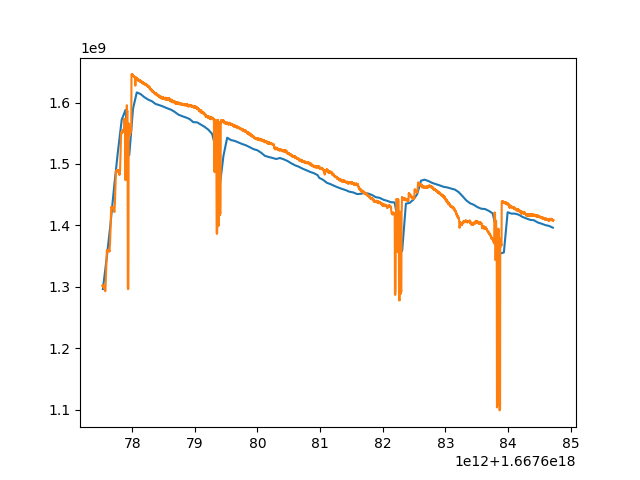

In [8]:
plt.figure()
data = 1e6*database[beams[1]['bb_Luminosity']['ATLAS']].dropna()
plt.plot(data.apply(lambda line: np.sum(line)))

data = 1e6*database[beams[1]['bb_Luminosity']['CMS']].dropna()
plt.plot(data.apply(lambda line: np.sum(line)))

In [15]:
database.dropna(subset=['bb_LUMI_TOT'])[['Timestamp','bb_LUMI_TOT']]

Timestamp  \
unix                                            
1.667678e+18 2022-11-05 20:45:31.783086+01:00   
1.667678e+18 2022-11-05 20:45:31.783086+01:00   
1.667678e+18 2022-11-05 20:46:32.092798+01:00   
1.667678e+18 2022-11-05 20:46:32.092798+01:00   
1.667678e+18 2022-11-05 20:47:32.226333+01:00   
...                                       ...   
1.667685e+18 2022-11-05 22:43:15.769420+01:00   
1.667685e+18 2022-11-05 22:44:15.797133+01:00   
1.667685e+18 2022-11-05 22:44:15.797133+01:00   
1.667685e+18 2022-11-05 22:45:16.062854+01:00   
1.667685e+18 2022-11-05 22:45:16.062854+01:00   

                                                    bb_LUMI_TOT  
unix                                                             
1.667678e+18  [0.0010861335, 0.0011863003, 0.0011628497, 0.0...  
1.667678e+18  [0.0010861335, 0.0011863003, 0.0011628497, 0.0...  
1.667678e+18  [0.0017868361, 0.0015816235, 0.0017577336, 0.0...  
1.667678e+18  [0.0017868361, 0.0015816235, 0.0017577336, 0.0...  
1.667678e+18  [0.0019128551, 0.0007146034, 0.0013809893, 0.0...  
...                                                         ...  
1.667685e+18  [0.0009855528, 0.0010388322, 0.0011535116, 0.0...  
1.667685e+18  [0.0010191877, 0.001154148, 0.00064273115, 0.0...  
1.667685e+18  [0.0010191877, 0.001154148, 0.00064273115, 0.0...  
1.667685e+18  [0.0010514141, 0.0013253015, 0.0011284621, 0.0...  
1.667685e+18  [0.0010514141, 0.0013253015, 0.0011284621, 0.0...  

[242 rows x 2 columns]

In [21]:
import scipy.interpolate as sciInterp

df = database.copy()
#----------------------------------------
# Luminosity is measured every minute, let's use it without too much manipulations
tmp = df.set_index('Time')['bb_LUMI_TOT'].dropna().index

# forcing constant time steps
dt    = 60
times = np.arange(tmp[0],tmp[-1],dt)
bins  = np.diff(times)/2 + times[:-1]
#-----------------------------------------

# Extracting data
#-----------------------------------------
observable     = f'bb_Intensity_avg_{beam.name}'
times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].dropna().to_2D()

observable     = 'bb_LUMI_TOT'
times_L,data_L = df.set_index('Time')[observable].dropna().to_2D()
#----------------------------------------


# Aligning times with interpolation
#---------------------------------
times   = times[10:-2]
data_N  =     sciInterp.interp1d(times_N,data_N,axis=0)(times)
data_L  = 1e6*sciInterp.interp1d(times_L,data_L,axis=0)(times)
#---------------------------------

# Computing xsection and lifetime
#---------------------------------
dNdt     = sEff.first_order_diff(data_N,dt)
xsection = -dNdt/data_L
lifetime = -data_N/dNdt
corrected = 3600*(-dNdt - 80e-3*data_L)/1e11
#---------------------------------


# UNPACKING RESULTS
bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
bin_timestamp = [pd.Timestamp(t).tz_localize('UTC').tz_convert(TZONE) for t in bin_unix]


results =  pd.DataFrame({'Time':times,'Timestamp':bin_timestamp,'corrected':list(corrected),'dNdt':list(dNdt),'Lifetime':list(lifetime),'sig_eff':list(xsection)},index=bin_unix)



/tmp/ipykernel_487218/321425847.py:35: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


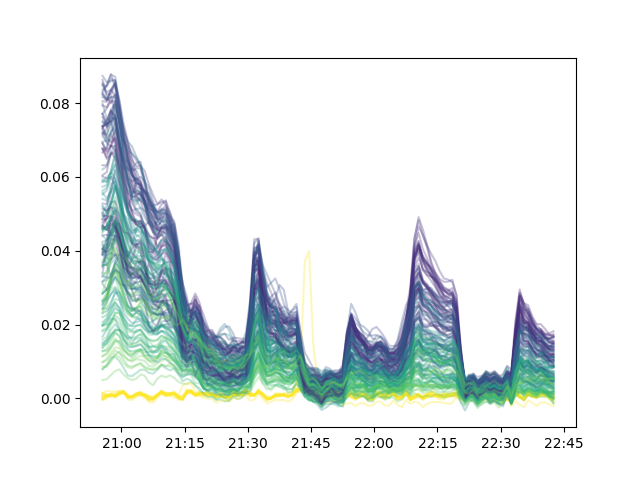

In [22]:
plt.figure()

tagged = patt.b2.bb_schedule.index

# Plotting all bunches
for bunch in tagged:

    ts       = results['Timestamp']
    #xsection = results['sig_eff'].apply(lambda line:line[bunch])
    corrected = results['corrected'].apply(lambda line:line[bunch])


    # Get dummy color
    sc = plt.scatter(buckets,np.nan*BB_signature,c = _colorby,vmin=vmin,vmax=vmax,cmap='viridis_r')
    plt.plot(ts       ,corrected      ,'-',alpha=0.3,color=sc.to_rgba(_colorby[bunch]))
            

/home/lumimod/MD8043/WireDAQ/SigmaEff.py:262: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:370: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:262: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:370: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


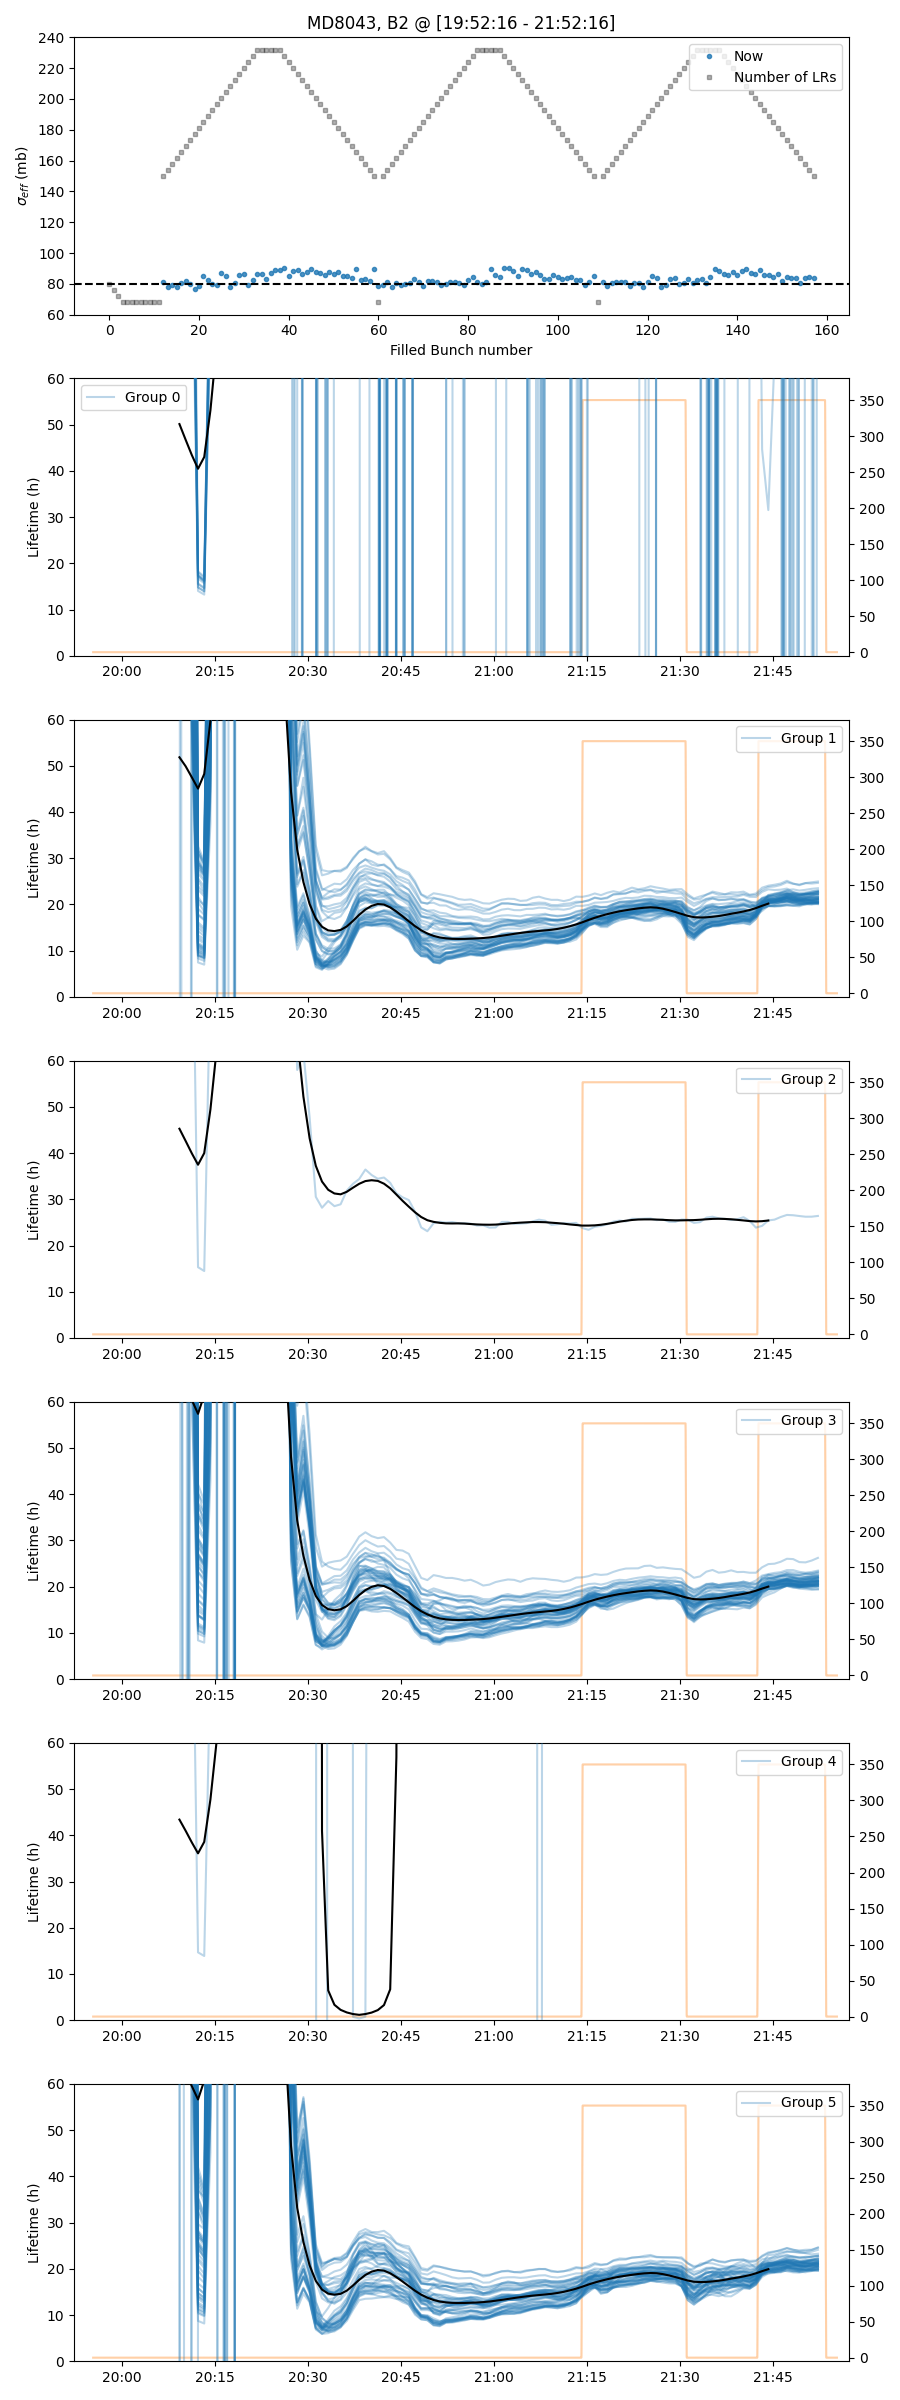

In [5]:
# With the diff, the last 2 minutes are lost
#last_time = database['Timestamp'].max() - pd.Timedelta(minutes=2)

# Computing effective cross section, both raw and smoothed 
xsection_df        = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]         = sEff.compute_lifetime_xsection(database,beam)
    xsection_smooth_df[beam.name]  = sEff.smooth_lifetime_xsection(database,beam)

beamName = 'B2'
    
last_time = xsection_df[beamName]['Timestamp'].max()
t0 = last_time - pd.Timedelta(minutes=configuration['prev_offset']+configuration['avg_window'])
t1 = last_time - pd.Timedelta(minutes=configuration['prev_offset'])
t2 = last_time - pd.Timedelta(minutes=configuration['avg_window'])
t3 = last_time

ylimits = [configuration['sig_lim_0'],configuration['sig_lim_1']]

time_window = [t3 - pd.Timedelta(minutes=configuration['buffer']),t3 + pd.Timedelta(minutes=5)]

for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    if beam.name != beamName.upper():
        continue

    # Choosing all bunches
    choosen_bunches = list(bb_df.index)
    
        
    fig, axes = plt.subplots(figsize=(9,24),ncols=1, nrows=7,gridspec_kw={'height_ratios': [1, 1,1,1,1,1,1]})
    
    # TOP PLOT
    #===============================================================================
    plt.sca(axes[0])

    plt.plot(xsection_df[beam.name].iloc[-1]['sig_eff'][choosen_bunches]/1e-3,'.',color='C0',alpha=0.8,label = 'Now')


    # Manual legend
    plt.plot([np.nan],[np.nan],'sk',ms=3,alpha=0.3,label = 'Number of LRs')
    plt.legend(loc='upper right')

    plt.axhline(80,ls='--',color='k')
    plt.ylim(ylimits)
    plt.xlabel('Filled Bunch number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)

    BB_signature = np.nan*np.ones(len(buckets))
    BB_signature[bb_df.index] =  bb_df['# of LR in ATLAS/CMS'].values
    plt.plot(BB_signature[choosen_bunches],'sk',ms=3,alpha=0.3,zorder=-10)

    #===============================================================================

    
    # BOTTOM PLOT
    #==============================================================================
    

    for name,group in bb_df.groupby('Train'):
        plt.sca(axes[int(name+1)])
        tagged = group.index

        # Plotting all bunches
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])


            plt.plot(ts       ,lifetime/3600       ,'-',alpha=0.3,color='C0')
        
        plt.plot([np.nan],[np.nan],'-',alpha=0.3,color='C0',label=f'Group {name}')
        plt.axhline(80,ls='--',color='k')
        plt.ylim([0,60])
        plt.xlim(time_window)
        plt.ylabel(r'Lifetime (h)')
        plt.legend()
        

        # Computing avg
        avg_ts              = xsection_smooth_df[beam.name]['Timestamp']
        avg_lifetime_smooth = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:np.mean(line[tagged]))
        plt.plot(avg_ts,avg_lifetime_smooth/3600,'-',alpha=1,color='k')

        # ADDING  WIRE IN BACKGROUND
        #==================================
        plt.gca().set_frame_on(False)
        ax2 = plt.gca().twinx()
        ax2.set_zorder(-1)
        #ax2.get_yaxis().set_visible(False)

        for wire in wires['B2']:
            database.nxPlot('Timestamp',wire.I,color='C1',alpha=0.2)
        plt.ylim([-5,380])


    plt.xlabel(r'Timestamp')
    axes[0].set_title(f'MD8043, {beam.name} @ [{str(time_window[0])[11:19]} - {str(xsection_df[beam.name]["Timestamp"].iloc[-1])[11:19]}]')
    plt.tight_layout()

In [4]:
xsection_df        = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]         = sEff.compute_lifetime_xsection(database,beam)
    xsection_smooth_df[beam.name]  = sEff.smooth_lifetime_xsection(database,beam)

beamName = 'B2'
    


/home/lumimod/MD8043/WireDAQ/SigmaEff.py:263: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:371: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:263: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:371: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


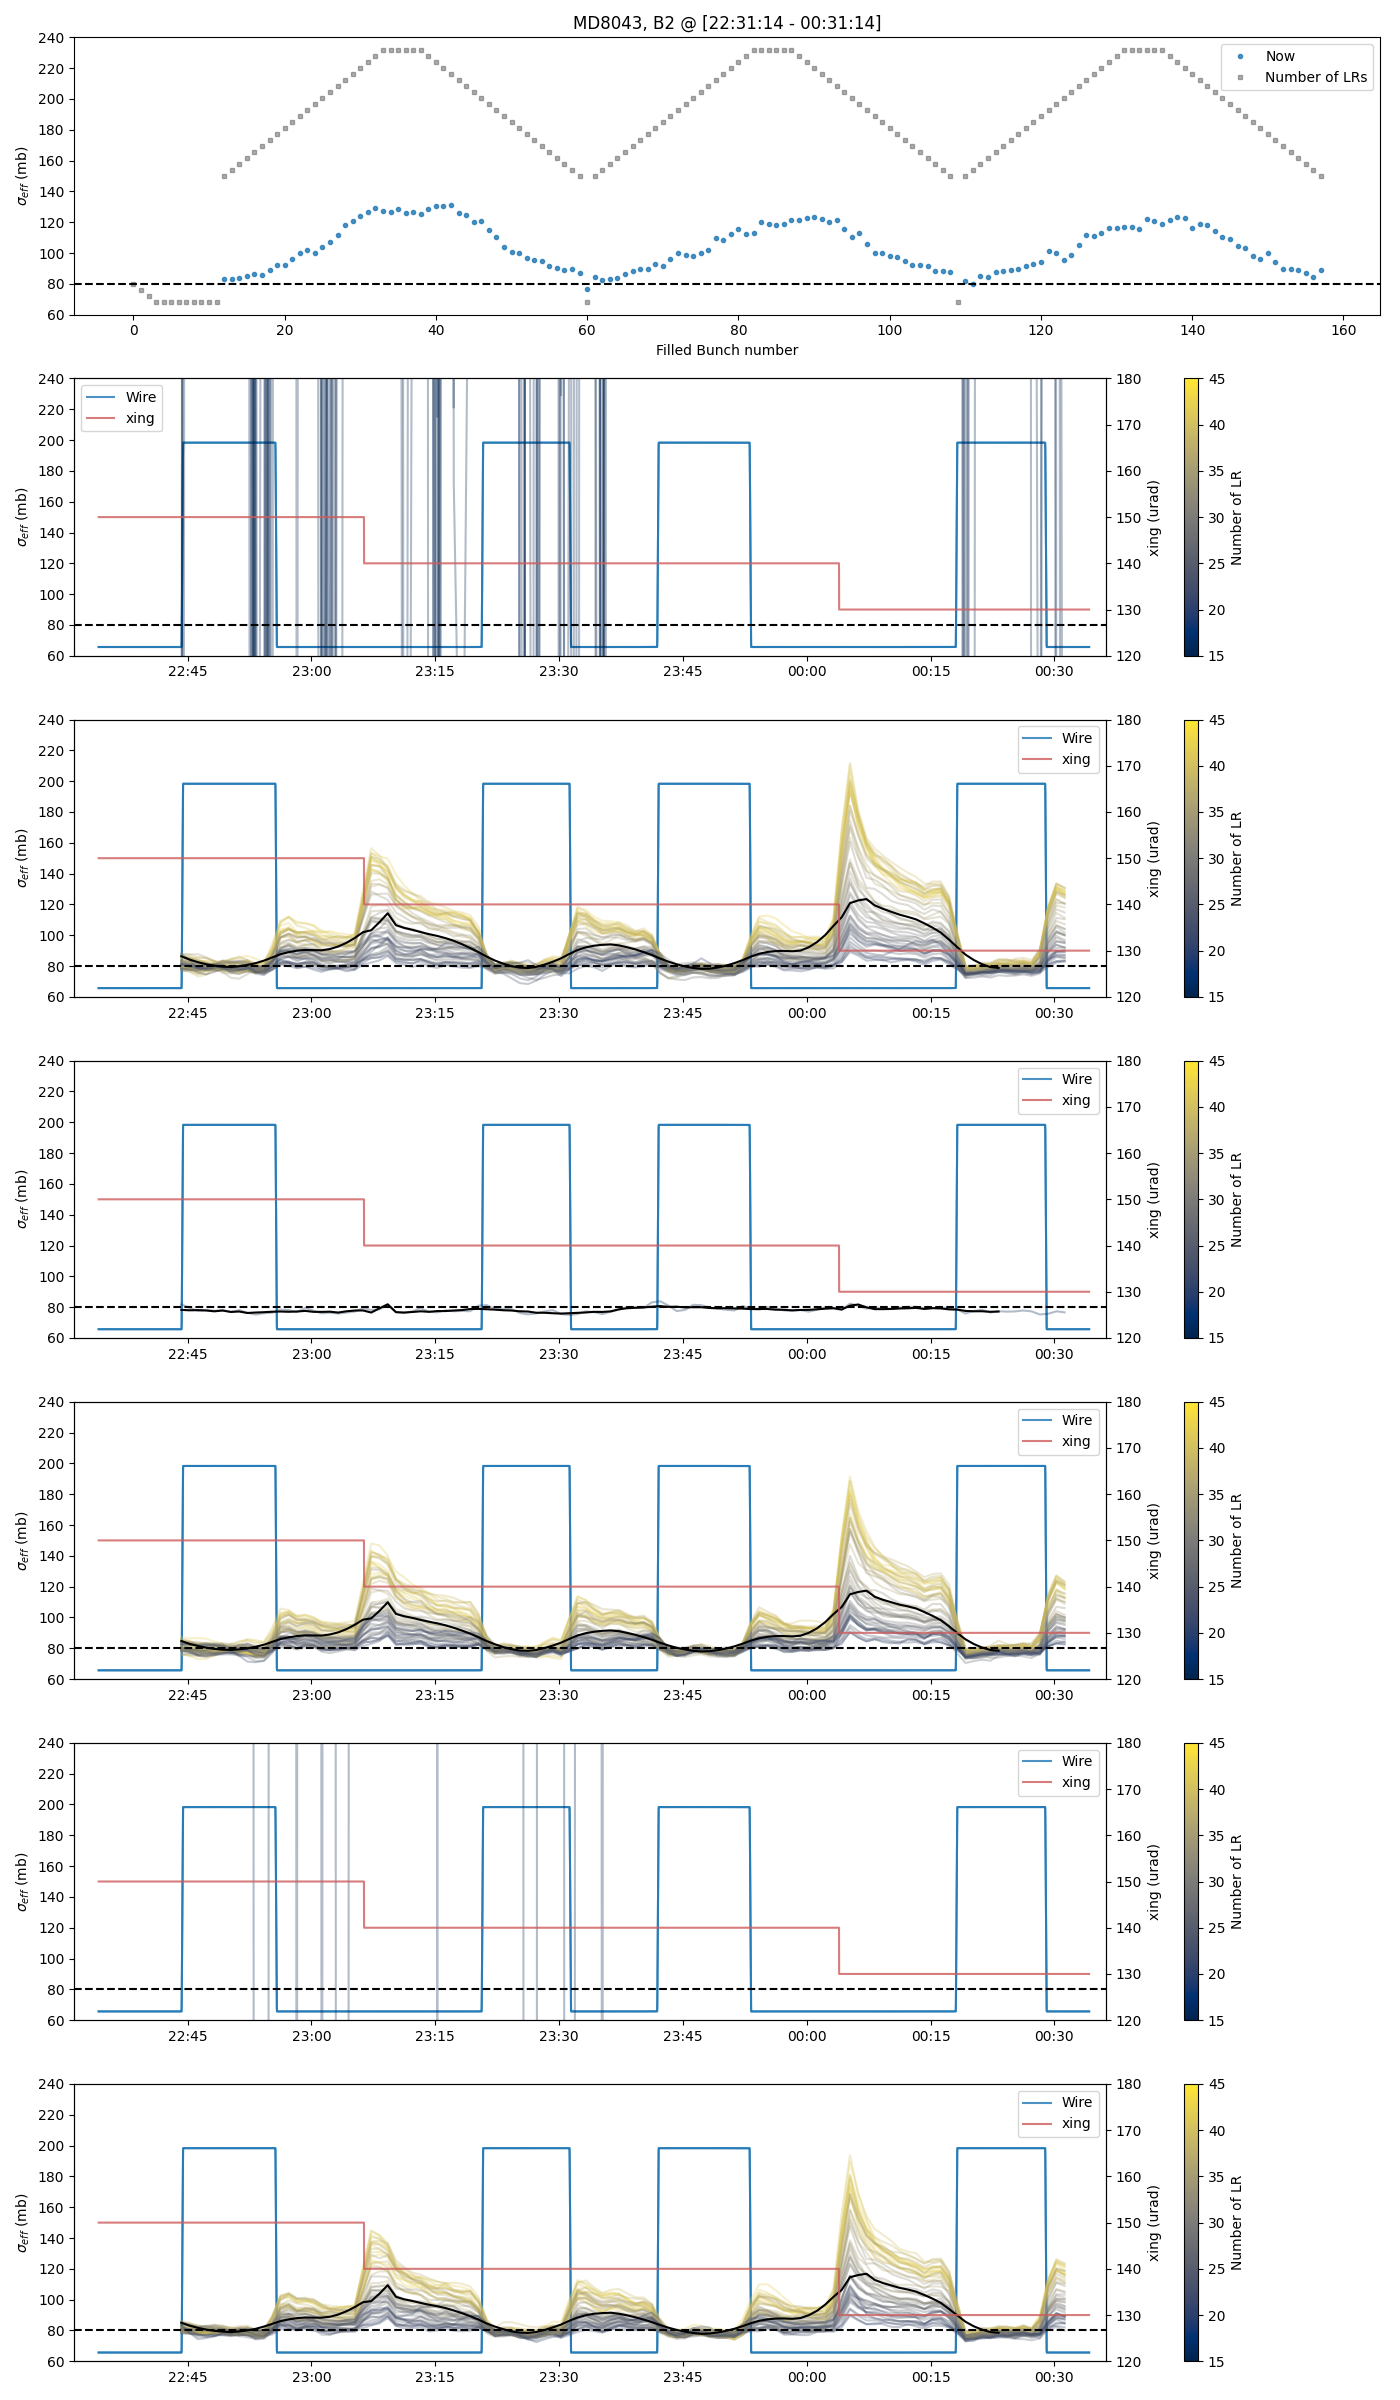

In [7]:

# With the diff, the last 2 minutes are lost
#last_time = database['Timestamp'].max() - pd.Timedelta(minutes=2)
last_time = xsection_df[beamName]['Timestamp'].max()
t0 = last_time - pd.Timedelta(minutes=configuration['prev_offset']+configuration['avg_window'])
t1 = last_time - pd.Timedelta(minutes=configuration['prev_offset'])
t2 = last_time - pd.Timedelta(minutes=configuration['avg_window'])
t3 = last_time

ylimits = [configuration['sig_lim_0'],configuration['sig_lim_1']]

time_window = [t3 - pd.Timedelta(minutes=configuration['buffer']),t3 + pd.Timedelta(minutes=5)]

for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    if beam.name != beamName.upper():
        continue

    # Choosing all bunches
    choosen_bunches = list(bb_df.index)
    
        
    fig, axes = plt.subplots(figsize=(9,24),ncols=1, nrows=7,gridspec_kw={'height_ratios': [1, 1,1,1,1,1,1]})
    
    # TOP PLOT
    #===============================================================================
    plt.sca(axes[0])

    plt.plot(xsection_df[beam.name].iloc[-1]['sig_eff'][choosen_bunches]/1e-3,'.',color='C0',alpha=0.8,label = 'Now')


    # Manual legend
    plt.plot([np.nan],[np.nan],'sk',ms=3,alpha=0.3,label = 'Number of LRs')
    plt.legend(loc='upper right')

    plt.axhline(80,ls='--',color='k')
    plt.ylim(ylimits)
    plt.xlabel('Filled Bunch number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)

    BB_signature = np.nan*np.ones(len(buckets))
    BB_signature[bb_df.index] =  bb_df['# of LR in ATLAS/CMS'].values
    plt.plot(BB_signature[choosen_bunches],'sk',ms=3,alpha=0.3,zorder=-10)

    #===============================================================================
    # COLORCODED
    #===============================

    TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0+50*1]
    study_bunches = bb_df.groupby('Train').get_group(TrainOI).index


    sc_label = f'Number of LR'
    _colorby = BB_signature#[choosen_bunches]
    vmin = 15#np.mean(cgrid)-1*np.std(cgrid)
    vmax = 45#np.mean(cgrid)+1*np.std(cgrid)
    #===============================
    
    # BOTTOM PLOT
    #==============================================================================
    

    for name,group in bb_df.groupby('Train'):
        plt.sca(axes[int(name+1)])
        tagged = group.index

        # Plotting all bunches
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            # Get dummy color
            sc = plt.scatter(buckets,np.nan*BB_signature,c = _colorby,vmin=vmin,vmax=vmax,cmap='cividis')

            # Plotting smotthed lines
            # plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(_colorby[bunch]))

            # plt.plot(ts       ,xsection/1e-3       ,'-',alpha=0.3,color='C0')
            plt.plot(ts       ,xsection/1e-3       ,'-',alpha=0.3,color=sc.to_rgba(_colorby[bunch]))
        
        cbar = plt.colorbar(pad=0.06)
        cbar.set_label(sc_label)

        #plt.plot([np.nan],[np.nan],'-',alpha=0.3,color='C0',label=f'Group {name}')
        plt.plot([np.nan],[np.nan],color='C0',alpha=0.8,label='Wire')
        plt.plot([np.nan],[np.nan],color='indianred',alpha=0.8,label='xing')
        plt.axhline(80,ls='--',color='k')
        plt.ylim(ylimits)
        plt.xlim(time_window)
        plt.ylabel(r'$\sigma_{eff}$ (mb)')
        plt.legend()
        

        # Computing avg
        avg_ts              = xsection_smooth_df[beam.name]['Timestamp']
        avg_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        plt.plot(avg_ts,avg_xsection_smooth/1e-3,'-',alpha=1,color='k')

        # ADDING  WIRE IN BACKGROUND
        #==================================
        plt.gca().set_frame_on(False)
        ax2 = plt.gca().twinx()
        ax2.set_zorder(-1)
        ax2.get_yaxis().set_visible(False)

        for wire in wires['B2']:
            database.nxPlot('Timestamp',wire.I,color='C0',alpha=0.8)
        plt.ylim([-15,460])

        ax3 = axes[int(name+1)].twinx()
        database.nxPlot('Timestamp','LhcStateTracker:LHCBEAM:IP5-XING-H-MURAD:target',color='indianred',alpha=0.8)
        plt.ylabel('xing (urad)\n')
        plt.ylim([120,180])
        


    plt.xlabel(r'Timestamp')
    axes[0].set_title(f'MD8043, {beam.name} @ [{str(time_window[0])[11:19]} - {str(xsection_df[beam.name]["Timestamp"].iloc[-1])[11:19]}]')
    plt.tight_layout()

In [28]:
database['LhcStateTracker:LHCBEAM:IP5-XING-H-MURAD:target'].dropna()

unix
1.667682e+18    160.0
1.667682e+18    160.0
1.667682e+18    160.0
1.667682e+18    160.0
1.667682e+18    160.0
                ...  
1.667689e+18    140.0
1.667689e+18    140.0
1.667689e+18    140.0
1.667689e+18    140.0
1.667689e+18    140.0
Name: LhcStateTracker:LHCBEAM:IP5-XING-H-MURAD:target, Length: 7032, dtype: float64

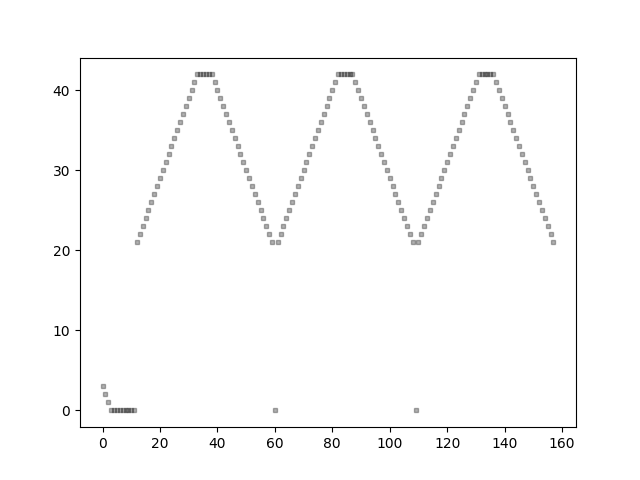

In [11]:
plt.figure()
plt.plot(BB_signature[choosen_bunches],'sk',ms=3,alpha=0.3,zorder=-10)

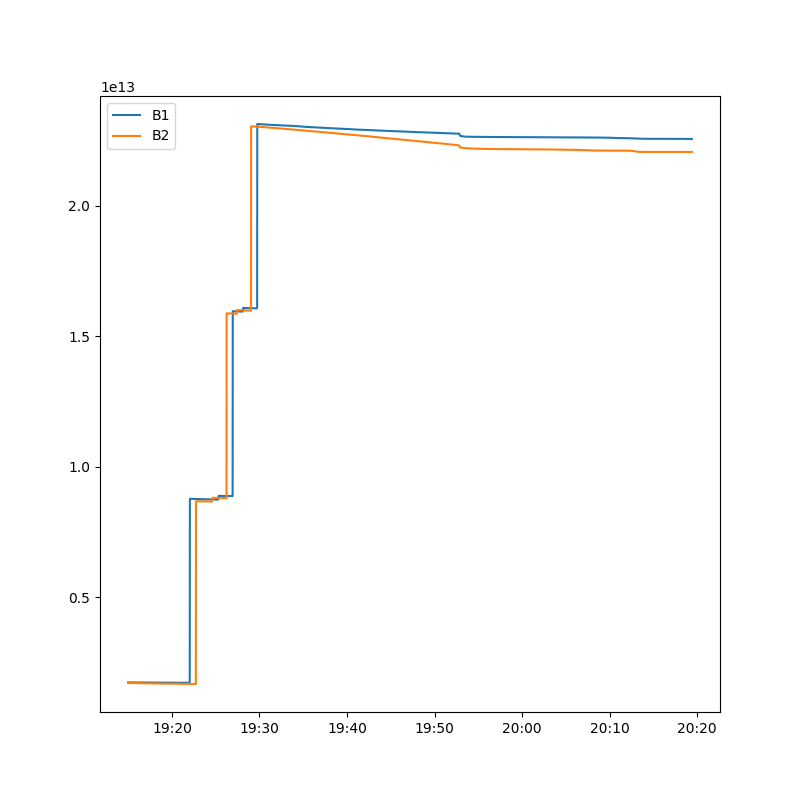

In [38]:
plt.figure(figsize=(8,8))
for beam in beams:
    database.nxPlot('Timestamp',beam.Intensity,label=beam.name)
plt.legend()

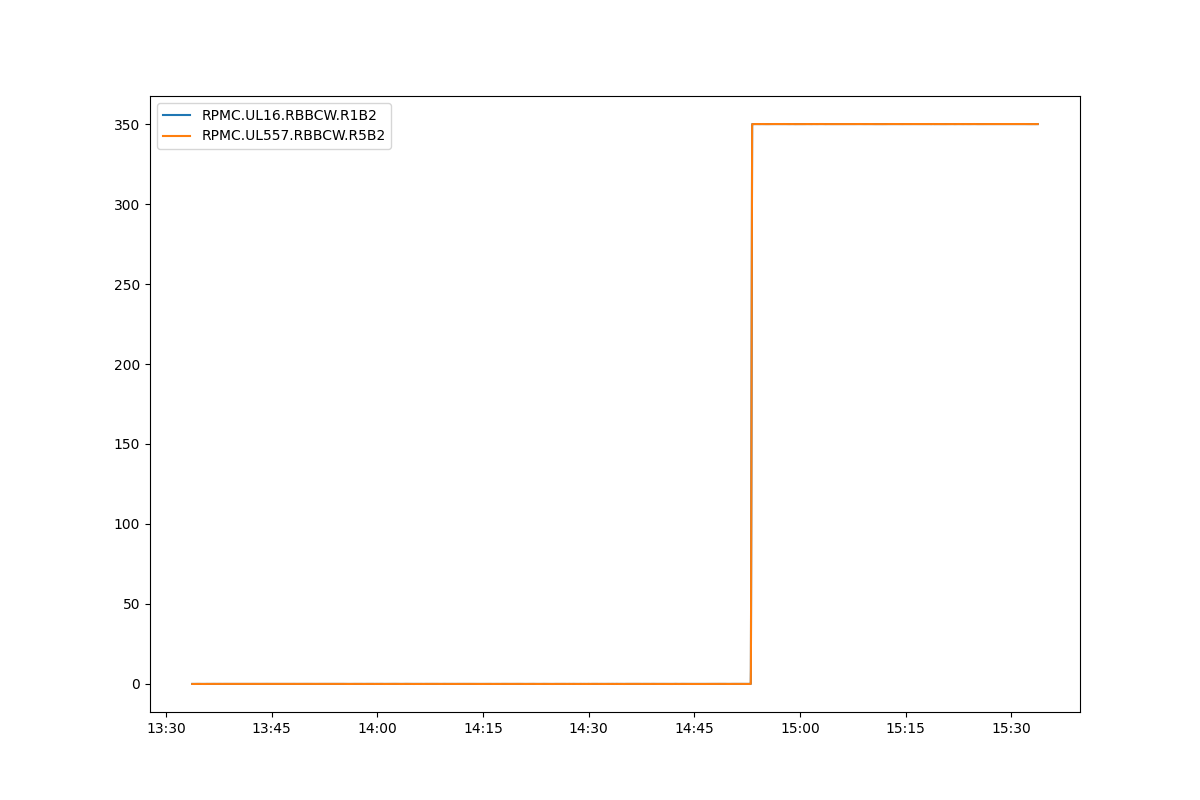

In [26]:
plt.figure(figsize=(12,8))
for wire in wires['B2']:
    database.nxPlot('Timestamp',wire.I,label=wire.name)
plt.legend()

---
# Load xsection dfs
---

In [21]:

# Loading effective cross section df
#-----------------------------------
xsection_df = {}
xsection_smooth_df = {}
for beam in beams:
    df_path = configuration['analysis_path'] + f'/{beam.name}/xsection/'
    
    filePool = sorted(list(Path(df_path).glob('xsection_2*')))
    xsection_df[beam.name] = pd.read_pickle(filePool[-1])

    filePool = sorted(list(Path(df_path).glob('xsection_smooth_2*')))
    xsection_smooth_df[beam.name] = pd.read_pickle(filePool[-1])
#-----------------------------------

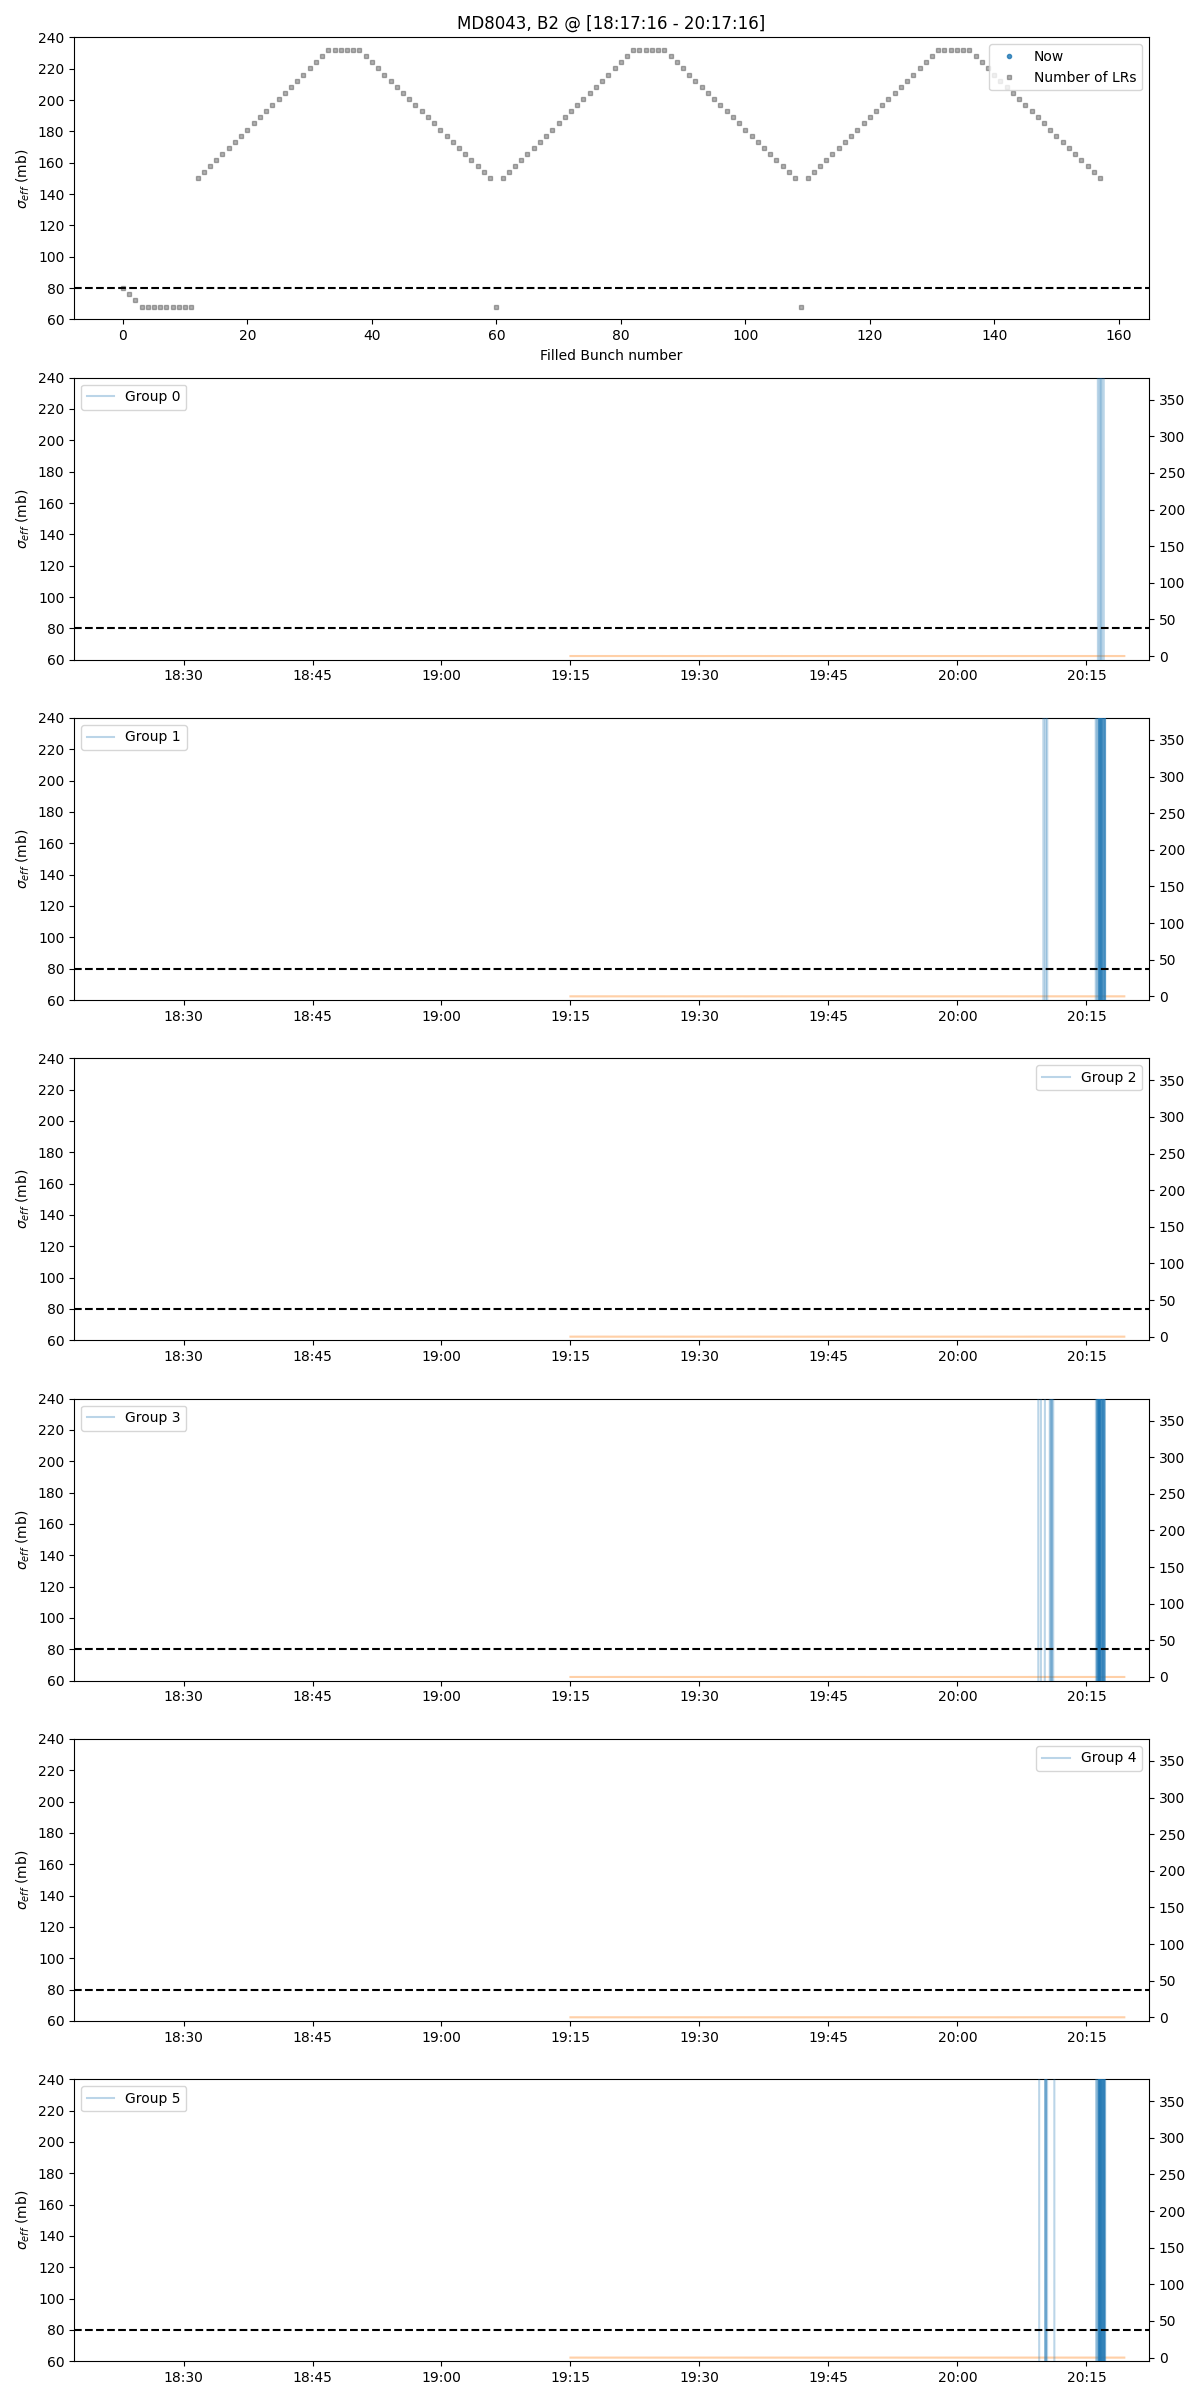

In [37]:
MDplt.plot_000_wire(database,xsection_df,xsection_smooth_df,'B2',patt,configuration)

TypeError: 'float' object is not subscriptable

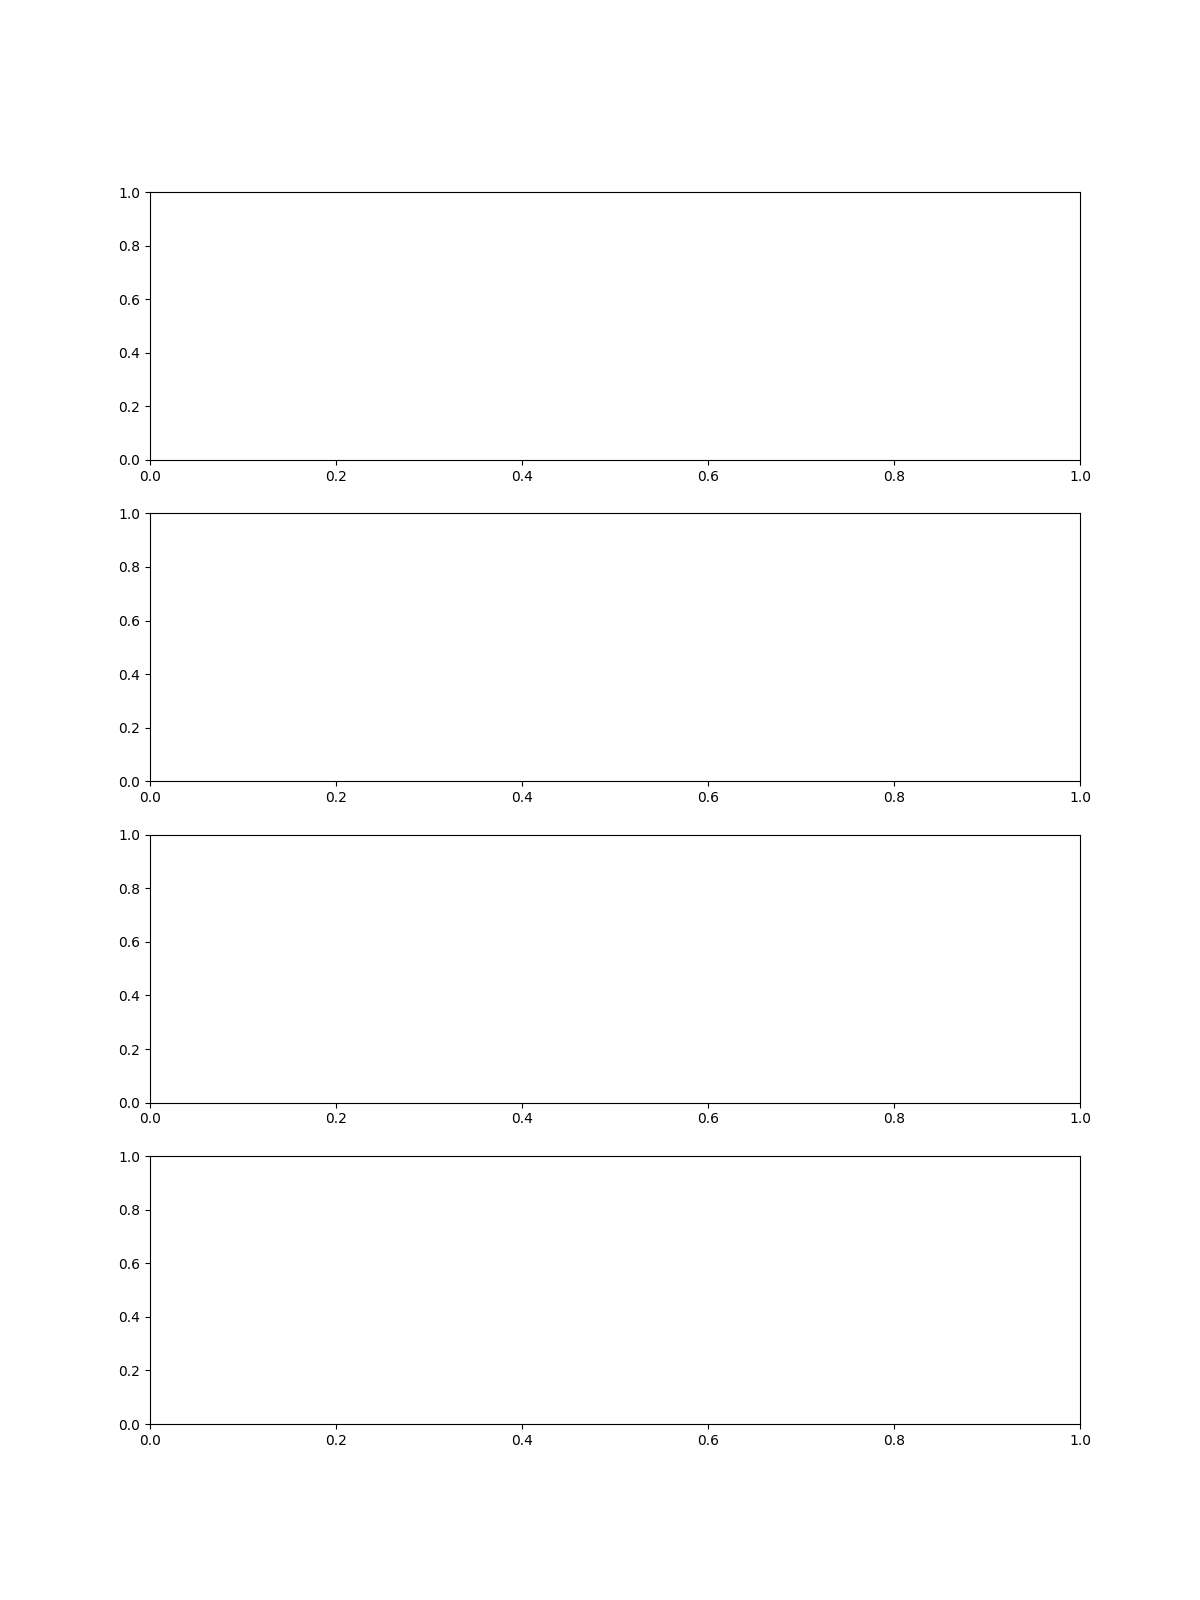

In [36]:
MDplt.plot_001_wire(database,xsection_df,xsection_smooth_df,'B2',patt,configuration)

---
# Lifetime Only
---

In [16]:
import scipy.interpolate as sciInterp

In [19]:
bins

array([6560.559506, 6620.559506, 6680.559506, 6740.559506, 6800.559506])

In [22]:
df = database.copy()
#----------------------------------------
# Luminosity is measured every minute, let's use it without too much manipulations
tmp = df.set_index('Time')['bb_LUMI_TOT'].dropna().index

# forcing constant time steps
dt    = 60
times = np.arange(tmp[0],tmp[-1],dt)
bins  = np.diff(times)/2 + times[:-1]
#-----------------------------------------

# Extracting data
#-----------------------------------------
observable     = f'bb_Intensity_avg_{beam.name}'
times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].dropna().to_2D()

observable     = 'bb_LUMI_TOT'
times_L,data_L = df.set_index('Time')[observable].dropna().to_2D()
#----------------------------------------


# Aligning times with interpolation
#---------------------------------
times   = times[2:-2]
data_N  =     sciInterp.interp1d(times_N,data_N,axis=0)(times)
data_L  = 1e6*sciInterp.interp1d(times_L,data_L,axis=0)(times)
#---------------------------------

# Computing xsection and lifetime
#---------------------------------
dNdt     = sEff.first_order_diff(data_N,dt)
xsection = -dNdt/data_L
lifetime = -data_N/dNdt
#---------------------------------


# UNPACKING RESULTS
bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
bin_timestamp = [pd.Timestamp(t).tz_localize('UTC').tz_convert(TZONE) for t in bin_unix]


/tmp/ipykernel_381800/3143267496.py:33: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


In [35]:

# Computing effective cross section, both raw and smoothed 
xsection_df        = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]         = sEff.compute_lifetime_xsection(database,beam)
    xsection_smooth_df[beam.name]  = sEff.smooth_lifetime_xsection(database,beam)

/home/lumimod/MD8043/WireDAQ/SigmaEff.py:262: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:370: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:262: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:370: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


In [26]:

# Computing effective cross section, both raw and smoothed 
xsection_df        = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]         = sEff.compute_lifetime_only(database,beam)
    xsection_smooth_df[beam.name]  = sEff.smooth_lifetime_only(database,beam)

/home/lumimod/MD8043/WireDAQ/SigmaEff.py:215: RuntimeWarning: divide by zero encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:215: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:314: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:215: RuntimeWarning: divide by zero encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:215: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/lumimod/MD8043/WireDAQ/SigmaEff.py:314: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


In [12]:
xsection_df['B2']

Time                        Timestamp  \
1.667675e+18  6650.56 2022-11-05 20:01:16.140000+01:00   
1.667675e+18  6660.56 2022-11-05 20:01:26.140000+01:00   
1.667675e+18  6670.56 2022-11-05 20:01:36.140000+01:00   
1.667675e+18  6680.56 2022-11-05 20:01:46.140000+01:00   
1.667675e+18  6690.56 2022-11-05 20:01:56.140000+01:00   
1.667675e+18  6700.56 2022-11-05 20:02:06.140000+01:00   
1.667675e+18  6710.56 2022-11-05 20:02:16.140000+01:00   
1.667675e+18  6720.56 2022-11-05 20:02:26.140000+01:00   
1.667675e+18  6730.56 2022-11-05 20:02:36.140000+01:00   
1.667675e+18  6740.56 2022-11-05 20:02:46.140000+01:00   
1.667675e+18  6750.56 2022-11-05 20:02:56.140000+01:00   
1.667675e+18  6760.56 2022-11-05 20:03:06.140000+01:00   
1.667675e+18  6770.56 2022-11-05 20:03:16.140000+01:00   
1.667675e+18  6780.56 2022-11-05 20:03:26.140000+01:00   
1.667675e+18  6790.56 2022-11-05 20:03:36.140000+01:00   
1.667675e+18  6800.56 2022-11-05 20:03:46.140000+01:00   
1.667675e+18  6810.56 2022-11-05 20:03:56.140000+01:00   
1.667675e+18  6820.56 2022-11-05 20:04:06.140000+01:00   
1.667675e+18  6830.56 2022-11-05 20:04:16.140000+01:00   
1.667675e+18  6840.56 2022-11-05 20:04:26.140000+01:00   

                                                           dNdt  \
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.667675e+18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                       Lifetime  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1.667675e+18  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...

In [25]:
patt.b2.bb_schedule.index

Int64Index([  30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
            ...
            2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623],
           dtype='int64', length=158)

In [28]:
lifetime

1.667675e+18    2.259946e+05
1.667675e+18    2.259846e+05
1.667675e+18    2.629753e+05
1.667675e+18    3.144552e+05
1.667675e+18    1.922477e+05
1.667675e+18    1.384358e+05
1.667675e+18    1.487804e+05
1.667675e+18    1.607993e+05
1.667675e+18    2.053248e+05
1.667675e+18    2.839724e+05
1.667675e+18    4.982777e+05
1.667675e+18    2.031548e+06
1.667675e+18    4.514529e+05
1.667675e+18    2.539323e+05
1.667675e+18    1.698933e+05
1.667675e+18    1.276406e+05
1.667675e+18    1.671909e+05
1.667675e+18    2.422814e+05
1.667675e+18    2.509569e+05
1.667675e+18    2.602784e+05
Name: Lifetime, dtype: float64

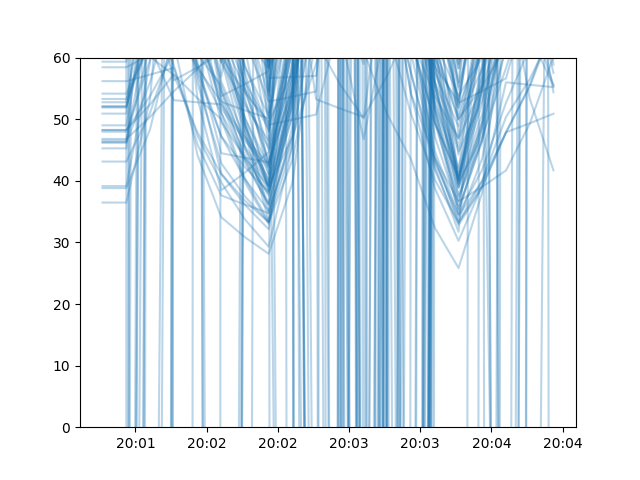

In [30]:
plt.figure()

tagged = patt.b2.bb_schedule.index
for bunch in tagged:

    ts       = xsection_df[beam.name]['Timestamp']
    # xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
    lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])
    plt.plot(ts       ,lifetime/3600       ,'-',alpha=0.3,color='C0')

    plt.ylim([0,60])